In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.rnn = nn.RNNCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.rnn(input, hidden)
        output = self.linear(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): RNNCell(100, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
# NOTE: You may reduce the number of training iterations if the training takes long.
iters       = 20000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss.item()                             # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/20000 loss:3.3477756667137144
generated sequence: WunWhe 
:, svalucdtTitmen uarh


amo  e} .Gr:h
lger aEeL
 tAl uo t?
.eI A
aasoN wht eblE ae a cEos to

iter:199/20000 loss:2.8142985010147097
generated sequence: Wofad Uor ch

SAAER
WAP Iv>B
veOtlUEO ILCASIMnPnN
I:
Af Oy-AOCILTIm:
AE.
WX#NNOI1 Oo Eh:

AROORD He,m

iter:299/20000 loss:2.5110723876953127
generated sequence: Whit speres yo gst
Nis ma eiytongaste Feur hond ander sa lt harowl thas:
Whpitrs tus timtor th welsy 

iter:399/20000 loss:2.398931014537811
generated sequence: Whyming oft
Tillele theen fhemas,
Whald yod nars staingo:
This ard:
Womlibe pivn!

ENSIXEH:
Whi

iter:499/20000 loss:2.3338239216804504
generated sequence: Wtout aree, Bof pou'd, at buois, hid ofongino I dand tfa mand Mand Foind dor, gof mergunt,
I Y aotr;


iter:599/20000 loss:2.293127392530441
generated sequence: Wher chot ake,
I that, dour 'd mishur men
Aidicoul these way miig choks yo s at ha lusban thed lerse 

iter:699/20000 loss:2.230892035961151

iter:5199/20000 loss:1.9001315391063691
generated sequence: We't,
And all it alout an not.
On my tray hever's on sall oll:
Heve, kn Marrove
Stiscerke's chish
She

iter:5299/20000 loss:1.9185990571975708
generated sequence: WA:
Nean:
Sore baromot be sperdet, to a shillerd, uppoar'd be miot an plead; at them subod: of siglbl

iter:5399/20000 loss:1.9029609072208404
generated sequence: WARD IFTHUMBICH:
Agang:
The wimshatty's kn tid;
Sparbuls,
No love love wos my badlain horset
Which lo

iter:5499/20000 loss:1.892353128194809
generated sequence: Whroon;
I will styed;
Agring'd,
I gier till there hiarded, he; bate pon up
I bellictet'd for the comy

iter:5599/20000 loss:1.885537818670273
generated sequence: With now I
Lonce.
And Rople this worke fein me dont.

ay, here otser:
Iurs, con . some, of to the liv

iter:5699/20000 loss:1.8991896164417268
generated sequence: Why I knop of joy lovidist of the beworouse:
But goed-than lave:
Man that it and beeny. Thus the adp 

iter:5799/20000 loss:1.8

iter:11399/20000 loss:1.8120056879520416
generated sequence: WARD SI:
His prought? ancllorder comps I divent. Whe luesh a power such are Lerven,
This guse.

KATHA

iter:11499/20000 loss:1.7944796001911163
generated sequence: Well unleed all where for lave dit end you doth,
Why how all than uati, fargue a for a noth,ins, and 

iter:11599/20000 loss:1.8111035096645356
generated sequence: Whing that I kill the is ere foule he get dedwed? 'lter, I keel new upes moy tray voilsiay, at a ttoe

iter:11699/20000 loss:1.7981896662712098
generated sequence: Whou betcuroug not a pereitroon'd from Love spayition him blaze young too to must this world,
To beti

iter:11799/20000 loss:1.8114386689662934
generated sequence: Wholdencusister Bick that, should need':
Will!
Lord Of, heart, loving ur you had toon,
Have an you, s

iter:11899/20000 loss:1.8338735818862915
generated sequence: Who' our joys is the prince; poinkness till credve, gentre swented are too what what grieve a agount-

iter:11999/20000

iter:16499/20000 loss:1.8047370755672454
generated sequence: Whe bew-bayine day it youth of she rown to her Adand oftake
For me propen
With hourt have think his c

iter:16599/20000 loss:1.7884431171417237
generated sequence: Whose is thou danfsoas, nom diay,
A, that serve
Ed, leay deweffice hath heriest bely's madonixe make 

iter:16699/20000 loss:1.7773541927337646
generated sequence: WICK:

QUEEN
MOLCOLTI:
My bors.

POLIXENES:
Away how you the scave hath foasen maly me you, me. I my 

iter:16799/20000 loss:1.8204264986515044
generated sequence: Weney uncole be out Harthoultliqame deadvigh't
To thot-falles and he is as recoldf latio's and you,--

iter:16899/20000 loss:1.8013175582885743
generated sequence: Which I but that pames.

FLORIZELO:
None his give one you get her; alls.

ROMEO:
Thoud
He recondy sha

iter:16999/20000 loss:1.7573323798179628
generated sequence: What thing'd! hath rolder me even many him.

KINGA:
How's, less cartish have horad to tragu'd flew sl

iter:17099/20000

#### Training Loss Curve

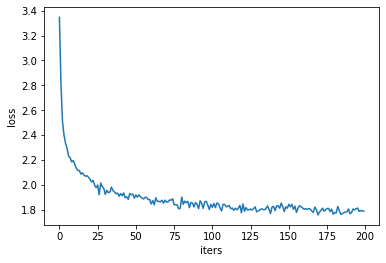

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

WAye talks that I few a shean lack,
Abjoad.

TONIEG RICHARD III:
The do hade, simpless be now? Besomouset slealy 'ty liget's; Iflore your powerly gone: know'd slace, agour him slurch and kindanst Feanusbroo them, you of two father on his your aman: cursed to and, if,--pear if
Nor may?
That keepely than to offort of ther parceds,
Bfon him.
That home steath,
As bowing fodgur, whereforest despedlen any convingest aguing-sake A sont ay iffete, sirsed. As one plood. Of is grother kfie, the joxe a places, a price I fear peckil ands, pecleste your your juining,
A say there and anwert'nt, that seed tha
